<a href="https://colab.research.google.com/github/safwanshamsir99/Industrial-Defect-Segementation-using-Computer-Vision/blob/main/Defect_Localization_for_Instance_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handson 3: Industrial Defect Localization

Industrial inspection is important for ensuring the quality and safety of products and infrastructure. It helps to identify defects and prevent failures, which can save companies time and money, and most importantly, ensure public safety.

MVTec AD is a dataset for benchmarking anomaly detection methods with a focus on industrial inspection. It contains over 5000 high-resolution images divided into fifteen different object and texture categories. Each category comprises a set of defect-free training images and a test set of images with various kinds of defects as well as images without defects.

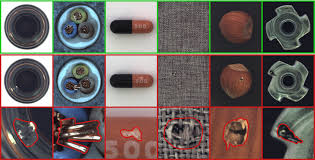

In this exercise, we focus on the **Wood** category. This Wood defect localization dataset is a curated collection of images and masks aimed at detecting and pinpointing defects in wood. Focusing solely on wooden materials, it covers a wide array of industrial and manufacturing scenarios. Its main purpose is to support the creation of AI models that can accurately identify and locate defects within wooden structures.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
HOME = '/content/drive/MyDrive/Day2/'
%cd {HOME}

/content/drive/MyDrive/Day2


In [ ]:
!unzip '/content/drive/MyDrive/Day2/mvtec-ad.zip'

Archive:  /content/drive/MyDrive/Day2/mvtec-ad.zip
replace mvtec-ad/grid/ground_truth/bent/000_mask.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mvtec-ad/grid/ground_truth/bent/000_mask.png  
  inflating: mvtec-ad/grid/ground_truth/bent/001_mask.png  
  inflating: mvtec-ad/grid/ground_truth/bent/002_mask.png  
  inflating: mvtec-ad/grid/ground_truth/bent/003_mask.png  
  inflating: mvtec-ad/grid/ground_truth/bent/004_mask.png  
  inflating: mvtec-ad/grid/ground_truth/bent/005_mask.png  
  inflating: mvtec-ad/grid/ground_truth/bent/006_mask.png  
  inflating: mvtec-ad/grid/ground_truth/bent/007_mask.png  
  inflating: mvtec-ad/grid/ground_truth/bent/008_mask.png  
  inflating: mvtec-ad/grid/ground_truth/bent/009_mask.png  
  inflating: mvtec-ad/grid/ground_truth/bent/010_mask.png  
  inflating: mvtec-ad/grid/ground_truth/bent/011_mask.png  
  inflating: mvtec-ad/grid/ground_truth/broken/000_mask.png  
  inflating: mvtec-ad/grid/ground_truth/broken/001_mask.png  
  inflating

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from PIL import Image
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

In [ ]:
# Define the paths to the folders
base_dir = "/content/drive/MyDrive/Day2/mvtec-ad/wood"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
gt_dir = os.path.join(base_dir, "ground_truth")

# Initialize lists to store data for DataFrame
data = []

# Handle "good" folder
# Gather images from "train" folder
train_good_dir = os.path.join(train_dir, "good")
if os.path.exists(train_good_dir):
    train_good_images = os.listdir(train_good_dir)
    for img_name in train_good_images:
        img_path = os.path.join(train_good_dir, img_name)
        mask_path = ""  # No mask for "good" category in train
        category = "good"
        mask = 0
        data.append([img_path, mask_path, category, mask])

# Gather images from "test/good" folder
test_good_dir = os.path.join(test_dir, "good")
if os.path.exists(test_good_dir):
    test_good_images = os.listdir(test_good_dir)
    for img_name in test_good_images:
        img_path = os.path.join(test_good_dir, img_name)
        mask_path = ""  # No mask for "good" category in test
        category = "good"
        mask = 0
        data.append([img_path, mask_path, category, mask])
# Handle ground truth folders
gt_categories = ["color", "combined", "hole", "liquid", "scratch"]
for category in gt_categories:
    test_category_dir = os.path.join(test_dir, category)
    gt_category_dir = os.path.join(gt_dir, category)
    if os.path.exists(test_category_dir) and os.path.exists(gt_category_dir):
        test_images = os.listdir(test_category_dir)
        for img_name in test_images:
            img_path = os.path.join(test_category_dir, img_name)
            mask_name = img_name.split('.')[0] + "_mask.png"
            mask_path = os.path.join(gt_category_dir, mask_name)
            mask_category = category
            mask = 1
            data.append([img_path, mask_path, mask_category, mask])


# Create a DataFrame
df = pd.DataFrame(data, columns=["image_path", "mask_path", "categories", "mask"])

# Display the DataFrame
print(df)


                                            image_path  \
0    /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...   
1    /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...   
2    /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...   
3    /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...   
4    /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...   
..                                                 ...   
321  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
322  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
323  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
324  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
325  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   

                                             mask_path categories  mask  
0                                                            good     0  
1                                                            good     0  
2                                                            good     0  
3      

In [ ]:
# Define image dimensions
width, height = 1024, 1024

# Create a solid black image using NumPy
black_image_array = np.zeros((height, width, 3), dtype=np.uint8)
black_image = Image.fromarray(black_image_array)

In [ ]:
df = pd.DataFrame(data, columns=["image_path", "mask_path", "categories", "mask"])

# Fill the blank values in 'mask_path' column with the black image
for index, row in df.iterrows():
    if pd.isnull(row['mask_path']) or row['mask_path'] == '':
        black_image_path = f'black_image_{index}.png'  # Unique path for each image
        black_image.save(black_image_path)
        df.at[index, 'mask_path'] = black_image_path

print("DataFrame after filling blank values in 'mask_path' column:")
print(df)

DataFrame after filling blank values in 'mask_path' column:
                                            image_path  \
0    /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...   
1    /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...   
2    /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...   
3    /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...   
4    /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...   
..                                                 ...   
321  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
322  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
323  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
324  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
325  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   

                                             mask_path categories  mask  
0                                    black_image_0.png       good     0  
1                                    black_image_1.png       good     0  
2                    

In [ ]:
df.head()

image_path          mask_path  \
0  /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...  black_image_0.png   
1  /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...  black_image_1.png   
2  /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...  black_image_2.png   
3  /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...  black_image_3.png   
4  /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...  black_image_4.png   

  categories  mask  
0       good     0  
1       good     0  
2       good     0  
3       good     0  
4       good     0

In [ ]:
df.shape

(326, 4)

In [ ]:
df['categories'].value_counts()

categories
good        266
scratch      21
combined     11
hole         10
liquid       10
color         8
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  326 non-null    object
 1   mask_path   326 non-null    object
 2   categories  326 non-null    object
 3   mask        326 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 10.3+ KB


In [ ]:
df['mask'].value_counts()

mask
0    266
1     60
Name: count, dtype: int64

# PERFORM DATA AUGMENTATION

*Performing data augmentation is essential, particularly when dealing with **imbalanced mask vs. not_mask values**. It involves creating additional training samples by applying various transformations to the existing data. This helps address class imbalance and enhances model robustness by diversifying the dataset, making it more representative of real-world scenarios. Data augmentation techniques such as rotation, scaling, and flipping are commonly employed to create a balanced and enriched dataset for training machine learning models, ultimately improving their ability to handle imbalanced classes effectively.*

In [ ]:
# Get the dataframe containing Woods defected which have masks associated with them.
wood_df_mask = df[df['mask']==1]
wood_df_mask.shape

(60, 4)

In [ ]:
wood_df_mask

image_path  \
266  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
267  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
268  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
269  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
270  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
271  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
272  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
273  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
274  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
275  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
276  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
277  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
278  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
279  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
280  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
281  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
282  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
283  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
284  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
285  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
286  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
287  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
288  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
289  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
290  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
291  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
292  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
293  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
294  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
295  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
296  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
297  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
298  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
299  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
300  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
301  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
302  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
303  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
304  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
305  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
306  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
307  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
308  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
309  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
310  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
311  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
312  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
313  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
314  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
315  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
316  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
317  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
318  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
319  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
320  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
321  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
322  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
323  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
324  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
325  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   

                                             mask_path categories  mask  
266  /content/drive/MyDrive/Day2/mvtec-ad/wood/grou...      color     1  
267  /content/drive/MyDrive/Day2/mvtec-ad/wood/grou...      color     1  
268  /content/drive/MyDrive/Day2/mvtec-ad/wood/grou...      color     1  
269  /content/drive/MyDrive/Day2/mvtec-ad/wood/grou...      color     1  
270  /content/drive/MyDrive/Day2/mvtec-ad/wood/grou...      color     1  
271  /content/drive/MyDrive/Day2/mvtec-ad/wood/grou...      c

In [ ]:
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

# Define the augmentation transformations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    ToTensorV2(),
])

# Create directories to save augmented images and masks
output_image_dir = '/content/drive/MyDrive/Day2/aug/image/'
output_mask_dir = '/content/drive/MyDrive/Day2/aug/mask/'
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# Initialize a list to store augmented data
augmented_data = []

# Loop through each row in wood_df_mask
for index, row in wood_df_mask.iterrows():
    image_path = row['image_path']
    mask_path = row['mask_path']
    category = row['categories']

    # Set 'mask' column to 1
    wood_df_mask.at[index, 'mask'] = 1

    # Load the image and mask
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))

    # Apply augmentations to both image and mask
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented['image']
    augmented_mask = augmented['mask']

    # Convert PyTorch tensor to NumPy array
    augmented_image = augmented_image.permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC

    # Ensure pixel values are in the range [0, 1] (undo normalization)
    augmented_image = augmented_image.astype(np.float32) / 255.0

    augmented_mask = augmented_mask.squeeze().cpu().numpy()  # Squeeze channel dimension
    augmented_mask[augmented_mask != 0] = 1  # Set all non-zero values to 1
    augmented_mask = (augmented_mask * 255).astype(np.uint8)

    # Save augmented images and masks
    image_filename = f'{category}_{index}_aug.png'
    mask_filename = f'{category}_{index}_aug_mask.png'
    augmented_image_path = os.path.join(output_image_dir, image_filename)
    augmented_mask_path = os.path.join(output_mask_dir, mask_filename)

    Image.fromarray((augmented_image * 255).astype(np.uint8)).save(augmented_image_path)  # Convert back to uint8
    Image.fromarray(augmented_mask).save(augmented_mask_path)

    # Append augmented data to the list
    augmented_data.append([augmented_image_path, augmented_mask_path, category, 1])

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Create a DataFrame for augmented data
augmented_df = pd.DataFrame(augmented_data, columns=["image_path", "mask_path", "categories", "mask"])

# Concatenate the original DataFrame 'df' with the augmented DataFrame
concatenated_df = pd.concat([df, augmented_df], ignore_index=True)

# Display the concatenated DataFrame
concatenated_df.tail(50)

image_path  \
336  /content/drive/MyDrive/Day2/aug/image/combined...   
337  /content/drive/MyDrive/Day2/aug/image/combined...   
338  /content/drive/MyDrive/Day2/aug/image/combined...   
339  /content/drive/MyDrive/Day2/aug/image/combined...   
340  /content/drive/MyDrive/Day2/aug/image/combined...   
341  /content/drive/MyDrive/Day2/aug/image/combined...   
342  /content/drive/MyDrive/Day2/aug/image/combined...   
343  /content/drive/MyDrive/Day2/aug/image/combined...   
344  /content/drive/MyDrive/Day2/aug/image/combined...   
345  /content/drive/MyDrive/Day2/aug/image/hole_285...   
346  /content/drive/MyDrive/Day2/aug/image/hole_286...   
347  /content/drive/MyDrive/Day2/aug/image/hole_287...   
348  /content/drive/MyDrive/Day2/aug/image/hole_288...   
349  /content/drive/MyDrive/Day2/aug/image/hole_289...   
350  /content/drive/MyDrive/Day2/aug/image/hole_290...   
351  /content/drive/MyDrive/Day2/aug/image/hole_291...   
352  /content/drive/MyDrive/Day2/aug/image/hole_292...   
353  /content/drive/MyDrive/Day2/aug/image/hole_293...   
354  /content/drive/MyDrive/Day2/aug/image/hole_294...   
355  /content/drive/MyDrive/Day2/aug/image/liquid_2...   
356  /content/drive/MyDrive/Day2/aug/image/liquid_2...   
357  /content/drive/MyDrive/Day2/aug/image/liquid_2...   
358  /content/drive/MyDrive/Day2/aug/image/liquid_2...   
359  /content/drive/MyDrive/Day2/aug/image/liquid_2...   
360  /content/drive/MyDrive/Day2/aug/image/liquid_3...   
361  /content/drive/MyDrive/Day2/aug/image/liquid_3...   
362  /content/drive/MyDrive/Day2/aug/image/liquid_3...   
363  /content/drive/MyDrive/Day2/aug/image/liquid_3...   
364  /content/drive/MyDrive/Day2/aug/image/liquid_3...   
365  /content/drive/MyDrive/Day2/aug/image/scratch_...   
366  /content/drive/MyDrive/Day2/aug/image/scratch_...   
367  /content/drive/MyDrive/Day2/aug/image/scratch_...   
368  /content/drive/MyDrive/Day2/aug/image/scratch_...   
369  /content/drive/MyDrive/Day2/aug/image/scratch_...   
370  /content/drive/MyDrive/Day2/aug/image/scratch_...   
371  /content/drive/MyDrive/Day2/aug/image/scratch_...   
372  /content/drive/MyDrive/Day2/aug/image/scratch_...   
373  /content/drive/MyDrive/Day2/aug/image/scratch_...   
374  /content/drive/MyDrive/Day2/aug/image/scratch_...   
375  /content/drive/MyDrive/Day2/aug/image/scratch_...   
376  /content/drive/MyDrive/Day2/aug/image/scratch_...   
377  /content/drive/MyDrive/Day2/aug/image/scratch_...   
378  /content/drive/MyDrive/Day2/aug/image/scratch_...   
379  /content/drive/MyDrive/Day2/aug/image/scratch_...   
380  /content/drive/MyDrive/Day2/aug/image/scratch_...   
381  /content/drive/MyDrive/Day2/aug/image/scratch_...   
382  /content/drive/MyDrive/Day2/aug/image/scratch_...   
383  /content/drive/MyDrive/Day2/aug/image/scratch_...   
384  /content/drive/MyDrive/Day2/aug/image/scratch_...   
385  /content/drive/MyDrive/Day2/aug/image/scratch_...   

                                             mask_path categories  mask  
336  /content/drive/MyDrive/Day2/aug/mask/combined_...   combined     1  
337  /content/drive/MyDrive/Day2/aug/mask/combined_...   combined     1  
338  /content/drive/MyDrive/Day2/aug/mask/combined_...   combined     1  
339  /content/drive/MyDrive/Day2/aug/mask/combined_...   combined     1  
340  /content/drive/MyDrive/Day2/aug/mask/combined_...   combined     1  
341  /content/drive/MyDrive/Day2/aug/mask/combined_...   combined     1  
342  /content/drive/MyDrive/Day2/aug/mask/combined_...   combined     1  
343  /content/drive/MyDrive/Day2/aug/mask/combined_...   combined     1  
344  /content/drive/MyDrive/Day2/aug/mask/combined_...   combined     1  
345  /content/drive/MyDrive/Day2/aug/mask/hole_285_...       hole     1  
346  /content/drive/MyDrive/Day2/aug/mask/hole_286_...       hole     1  
347  /content/drive/MyDrive/Day2/aug/mask/hole_287_...       hole     1  
348  /content/drive/MyDrive/Day2/aug/mask/hole_288_...       hole     1  
349  /content/drive/MyDrive/Day2/aug/mask/hole_28

In [ ]:
concatenated_df['mask'].value_counts()

mask
0    266
1    120
Name: count, dtype: int64

In [ ]:
concatenated_df.isnull().sum()

image_path    0
mask_path     0
categories    0
mask          0
dtype: int64

In [ ]:
# Before Data Augmentation
df['categories'].value_counts()

categories
good        266
scratch      21
combined     11
hole         10
liquid       10
color         8
Name: count, dtype: int64

In [ ]:
# After Data Augmentation
concatenated_df['categories'].value_counts()

categories
good        266
scratch      42
combined     22
hole         20
liquid       20
color        16
Name: count, dtype: int64

# PERFORM DATA VISUALIZATION

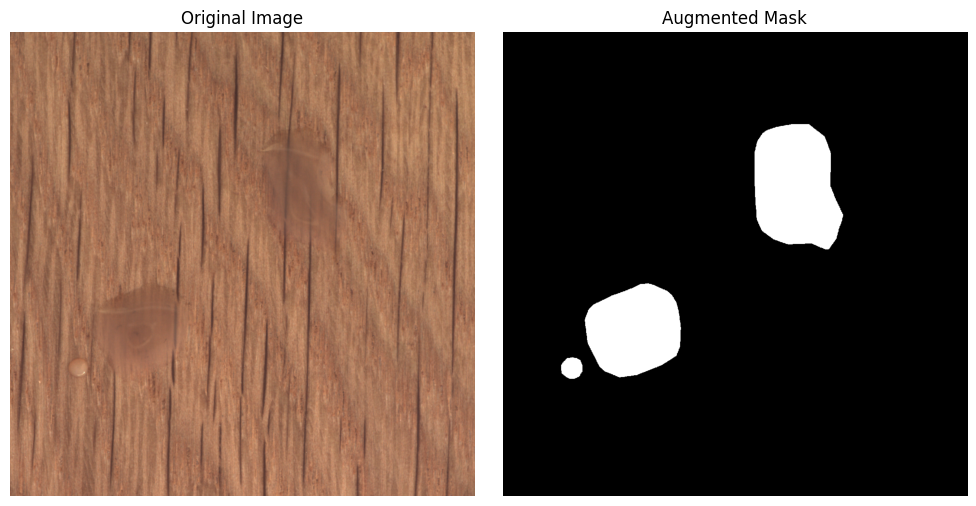

In [ ]:
import matplotlib.pyplot as plt

# Define the index you want to visualize
index_to_visualize = 362

# Get the image and mask paths for the selected index
image_path = concatenated_df.loc[index_to_visualize, 'image_path']
mask_path = concatenated_df.loc[index_to_visualize, 'mask_path']

# Load the image and mask using PIL
image = Image.open(image_path)
mask = Image.open(mask_path)

# Create a subplot to display the image and mask side by side
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

# Display the augmented mask
plt.subplot(1, 2, 2)
plt.title('Augmented Mask')
plt.imshow(mask, cmap='gray')  # Use 'gray' colormap for grayscale masks
plt.axis('off')

# Show the plots
plt.tight_layout()
plt.show()


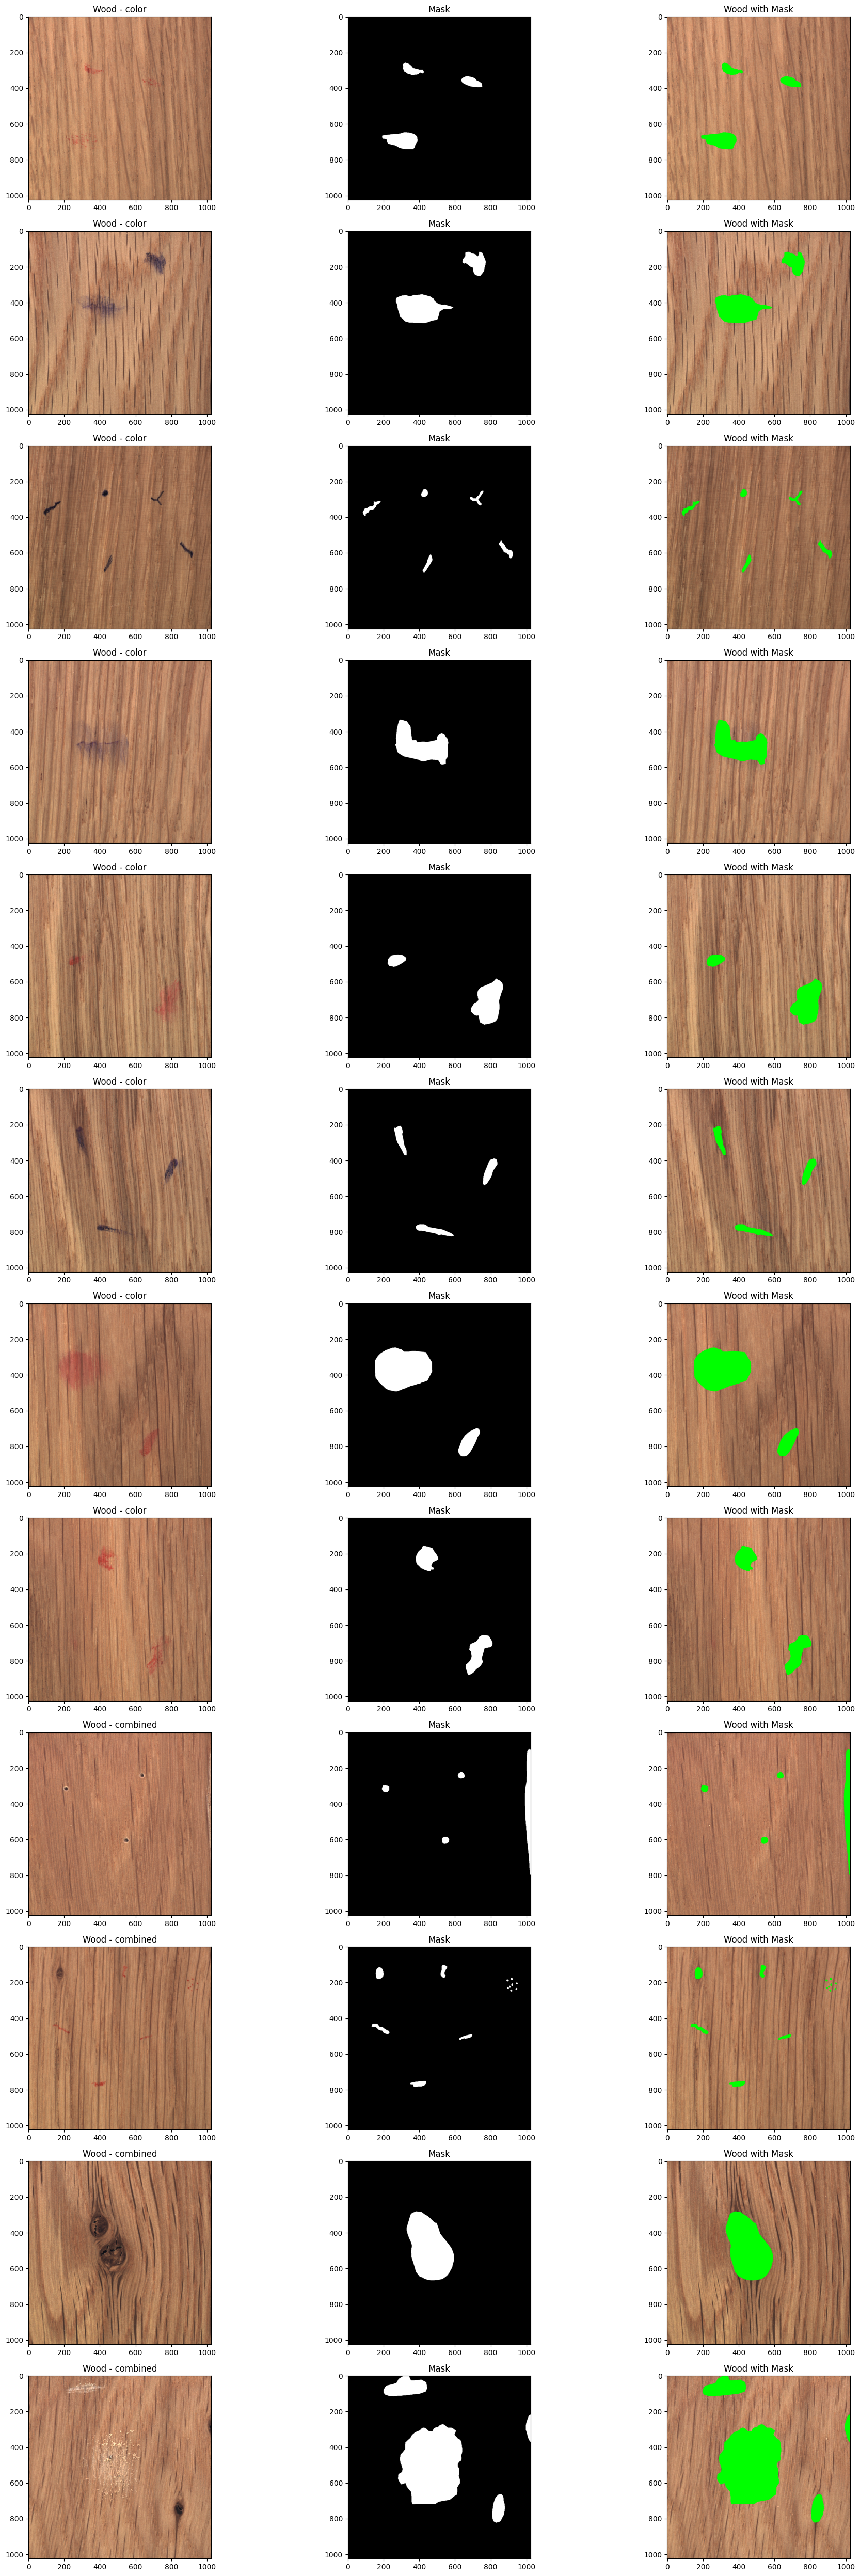

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(df)):
  if concatenated_df['mask'][i] ==1 and count <12:
    img = io.imread(concatenated_df.image_path[i])
    axs[count][0].title.set_text("Wood - " + str(concatenated_df['categories'][i]))
    axs[count][0].imshow(img)

    mask = io.imread(concatenated_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')


    img[mask == 255] = (0, 255, 0)
    axs[count][2].title.set_text('Wood with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

# TRAIN A CLASSIFIER MODEL TO DETECT IF DEFECTED OR NOT

In [ ]:
df_train = concatenated_df
df_train.shape

(386, 4)

In [ ]:
df_train['mask'] = df_train['mask'].apply(lambda x: str(x))

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  386 non-null    object
 1   mask_path   386 non-null    object
 2   categories  386 non-null    object
 3   mask        386 non-null    object
dtypes: object(4)
memory usage: 12.2+ KB


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train, test_size = 0.2)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes a validation split of 0.2
'''
NOTE: this is to generalize the data to pass to the model
'''
datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 247 validated image filenames belonging to 2 classes.
Found 61 validated image filenames belonging to 2 classes.
Found 78 validated image filenames belonging to 2 classes.


In [ ]:
# Load the InceptionV3 model
basemodel = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
basemodel.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 127, 127, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 127, 127, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 127, 127, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 125, 125, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 125, 125, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 125, 125, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 125, 125, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 125, 125, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 125, 125, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 62, 62, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 62, 62, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 62, 62, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 60, 60, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 60, 60, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
len(basemodel.layers)

311

In [ ]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D()(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
output_layer = Dense(2, activation='softmax')(headmodel)
model = Model(inputs=basemodel.input, outputs=output_layer)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

# Specify an absolute path for saving the weights
checkpoint_path = '/content/drive/MyDrive/Day2/classifier-resnet-weights.hdf5.keras'

# Update the ModelCheckpoint callback
checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)

# Use the updated checkpoint path in the fit function
history = model.fit(train_generator, steps_per_epoch=train_generator.n // 16, epochs=15, validation_data=valid_generator, validation_steps=valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6802 - loss: 0.8164
Epoch 1: val_loss improved from inf to 3.07432, saving model to /content/drive/MyDrive/Day2/classifier-resnet-weights.hdf5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.6883 - loss: 0.7957 - val_accuracy: 0.3958 - val_loss: 3.0743
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.8125 - loss: 0.6121

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 3.07432
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 575ms/step - accuracy: 0.8125 - loss: 0.6121 - val_accuracy: 0.1538 - val_loss: 6.6471
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.8797 - loss: 0.2692
Epoch 3: val_loss did not improve from 3.07432
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 889ms/step - accuracy: 0.8794 - loss: 0.2740 - val_accuracy: 0.2708 - val_loss: 11.6265
Epoch 4/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.8125 - loss: 0.4571
Epoch 4: val_loss did not improve from 3.07432
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8125 - loss: 0.4571 - val_accuracy: 0.3846 - val_loss: 25.2072
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.8231 - loss: 0.3913
Epoch 5: val_loss improved from 3.07432 to 2.35427, saving model to /content/drive/MyDrive/Day2/classifier-resnet-weights.hdf5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8241 - loss: 0.3892 - val_accuracy: 0.5208 - val_loss: 2.3543

In [ ]:
# save the model architecture to json file

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

# ASSESS TRAINED MODEL PERFORMANCE

In [ ]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 563ms/step


In [ ]:
test_predict.shape

(64, 2)

In [ ]:
# Obtain the predicted class from the model
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'],
      dtype='<U1')

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

64

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.640625

<Axes: >

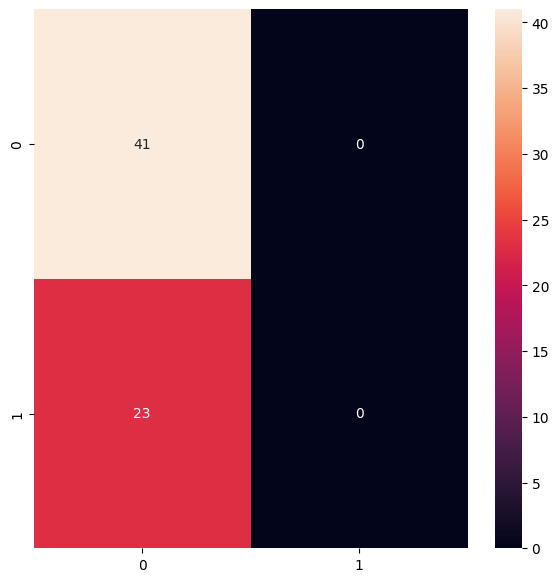

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.64      1.00      0.78        41
           1       0.00      0.00      0.00        23

   micro avg       0.64      0.64      0.64        64
   macro avg       0.32      0.50      0.39        64
weighted avg       0.41      0.64      0.50        64



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# BUILD A SEGMENTATION MODEL TO LOCALIZE THE DEFECTION

In [ ]:
concatenated_df['mask'] = concatenated_df['mask'].apply(lambda x: int(x))

In [ ]:
# Get the dataframe containing Woods defected which have masks associated with them.
wood_df_mask = concatenated_df[concatenated_df['mask']==1]
wood_df_mask.shape

(120, 4)

In [ ]:
wood_df_mask

image_path  \
266  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
267  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
268  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
269  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
270  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...   
..                                                 ...   
381  /content/drive/MyDrive/Day2/aug/image/scratch_...   
382  /content/drive/MyDrive/Day2/aug/image/scratch_...   
383  /content/drive/MyDrive/Day2/aug/image/scratch_...   
384  /content/drive/MyDrive/Day2/aug/image/scratch_...   
385  /content/drive/MyDrive/Day2/aug/image/scratch_...   

                                             mask_path categories  mask  
266  /content/drive/MyDrive/Day2/mvtec-ad/wood/grou...      color     1  
267  /content/drive/MyDrive/Day2/mvtec-ad/wood/grou...      color     1  
268  /content/drive/MyDrive/Day2/mvtec-ad/wood/grou...      color     1  
269  /content/drive/MyDrive/Day2/mvtec-ad/wood/grou...      color     1  
270  /content/drive/MyDrive/Day2/mvtec-ad/wood/grou...      color     1  
..                                                 ...        ...   ...  
381  /content/drive/MyDrive/Day2/aug/mask/scratch_3...    scratch     1  
382  /content/drive/MyDrive/Day2/aug/mask/scratch_3...    scratch     1  
383  /content/drive/MyDrive/Day2/aug/mask/scratch_3...    scratch     1  
384  /content/drive/MyDrive/Day2/aug/mask/scratch_3...    scratch     1  
385  /content/drive/MyDrive/Day2/aug/mask/scratch_3...    scratch     1  

[120 rows x 4 columns]

In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(wood_df_mask, test_size=0.2)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
'''
This custom datagenerator code is adapted from the Python code file "my_classes.py" located at the following GitHub repository:
https://github.com/afshinea/keras-data-generator/blob/master/my_classes.py

'''


#creating a custom datagenerator:

import cv2
import numpy as np
import tensorflow as tf
from skimage import io

# Creating a custom datagenerator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, ids, mask, image_dir='./', batch_size=8, img_h=256, img_w=256, shuffle=True):
        self.ids = ids
        self.mask = mask
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.ids)) / self.batch_size)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        list_ids = [self.ids[i] for i in indexes]
        list_mask = [self.mask[i] for i in indexes]
        X, y = self.__data_generation(list_ids, list_mask)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids, list_mask):
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

        for i in range(len(list_ids)):
            img_path = list_ids[i]
            mask_path = list_mask[i]
            img = io.imread(img_path)
            mask = io.imread(mask_path)
            img = cv2.resize(img, (self.img_h, self.img_w))
            img = np.array(img, dtype=np.float64)
            mask = cv2.resize(mask, (self.img_h, self.img_w))
            mask = np.array(mask, dtype=np.float64)

            img -= img.mean()
            img /= img.std()
            mask -= mask.mean()
            mask /= mask.std()

            X[i,] = img
            y[i,] = np.expand_dims(mask, axis=2)

        y = (y > 0).astype(int)

        return X, y

In [ ]:
def prediction(test, model, model_seg):
    '''
    Two shots prediction.
    1. Will predict if the model has mask or not
    2. Do image segmentation if the model predict the image has mask

    Args:
      - test: test data
      - model: model to predict the mask
      - model_seg: model to do image segmentation
    '''
    directory = "./"
    mask = []
    image_id = []
    has_mask = []

    for i in test.image_path:
        path = i
        img = io.imread(path)
        img = img * 1.0 / 255.
        img = cv2.resize(img, (256, 256))
        img = np.array(img, dtype=np.float64)
        img = np.reshape(img, (1, 256, 256, 3))
        is_defect = model.predict(img)

        if np.argmax(is_defect) == 0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask')
            continue

        img = io.imread(path)
        X = np.empty((1, 256, 256, 3))
        img = cv2.resize(img, (256, 256))
        img = np.array(img, dtype=np.float64)
        img -= img.mean()
        img /= img.std()
        X[0,] = img
        predict = model_seg.predict(X)

        if predict.round().astype(int).sum() == 0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask')
        else:
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)

    return image_id, mask, has_mask

In [ ]:
'''
In this exercise, we will try to use a custom loss function to train this ResUNet.The loss function as is obtained from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}
'''
def tversky(y_true, y_pred):
    smooth = 1.0  # Use a float value for smooth
    y_true_pos = K.flatten(K.cast(y_true, 'float32'))
    y_pred_pos = K.flatten(K.cast(y_pred, 'float32'))
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [ ]:
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
def resblock(X, f):


  # make a copy of input
  X_copy = X
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(64,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(64,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 128)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 256)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 512)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 1024)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 512)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 256)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 128)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 64)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [ ]:
model_seg.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 256, 256, 64)   │            256 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 256, 256, 64)   │            256 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 128, 128, 128)  │          8,320 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 128, 128, 128)  │            512 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 128, 128, 128)  │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 128, 128, 128)  │          8,320 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 128, 128, 128)  │            512 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_98    │ (None, 128, 128, 128)  │            512 │ conv2d_98[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 128, 128)  │              0 │ batch_normalization_9… │
│                           │                        │                │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 128, 128, 128)  │              0 │ add[0][0]              │
│ (Activation)         

 Total params: 19,231,297 (73.36 MB)

 Trainable params: 19,213,761 (73.29 MB)

 Non-trainable params: 17,536 (68.50 KB)

# TRAIN A SEGMENTATION RESUNET MODEL TO LOCALIZE DEFECTION

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate = 1e-4, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5.keras", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator, epochs = 400, validation_data = validation_generator)

Epoch 1/400


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 71s 907ms/step - loss: 0.9513 - tversky: 0.0644 - val_loss: 0.9999 - val_tversky: 7.0031e-05
Epoch 2/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 562ms/step - loss: 0.9398 - tversky: 0.0793 - val_loss: 0.9992 - val_tversky: 0.0011
Epoch 3/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 519ms/step - loss: 0.9392 - tversky: 0.0801 - val_loss: 0.9925 - val_tversky: 0.0100
Epoch 4/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 569ms/step - loss: 0.9403 - tversky: 0.0787 - val_loss: 0.9806 - val_tversky: 0.0258
Epoch 5/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 507ms/step - loss: 0.9373 - tversky: 0.0827 - val_loss: 0.9618 - val_tversky: 0.0506
Epoch 6/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 540ms/step - loss: 0.9486 - tversky: 0.0678 - val_loss: 0.9488 - val_tversky: 0.0677
Epoch 7/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 563ms/step - loss: 0.9468 - tversky: 0.0702 - val_loss: 0.9533 - val_tversky: 0.0618
Epoch 8/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 503ms/step - loss: 0.9502 - tversky: 0.0658 - val_loss: 0.9346 - val_

In [ ]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

# ASSESS TRAINED SEGMENTATION RESUNET MODEL PERFORMANCE

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path predicted_mask  has_mask
0   /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...        No mask         0
1   /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...        No mask         0
2   /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...        No mask         0
3   /content/drive/MyDrive/Day2/mvtec-ad/wood/test...        No mask         0
4   /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...        No mask         0
..                                                ...            ...       ...
73  /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...        No mask         0
74  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...        No mask         0
75  /content/drive/MyDrive/Day2/mvtec-ad/wood/test...        No mask         0
76  /content/drive/MyDrive/Day2/aug/image/hole_287...        No mask         0
77  /content/drive/MyDrive/Day2/mvtec-ad/wood/trai...        No mask         0

[78 rows x 3 columns]

In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')

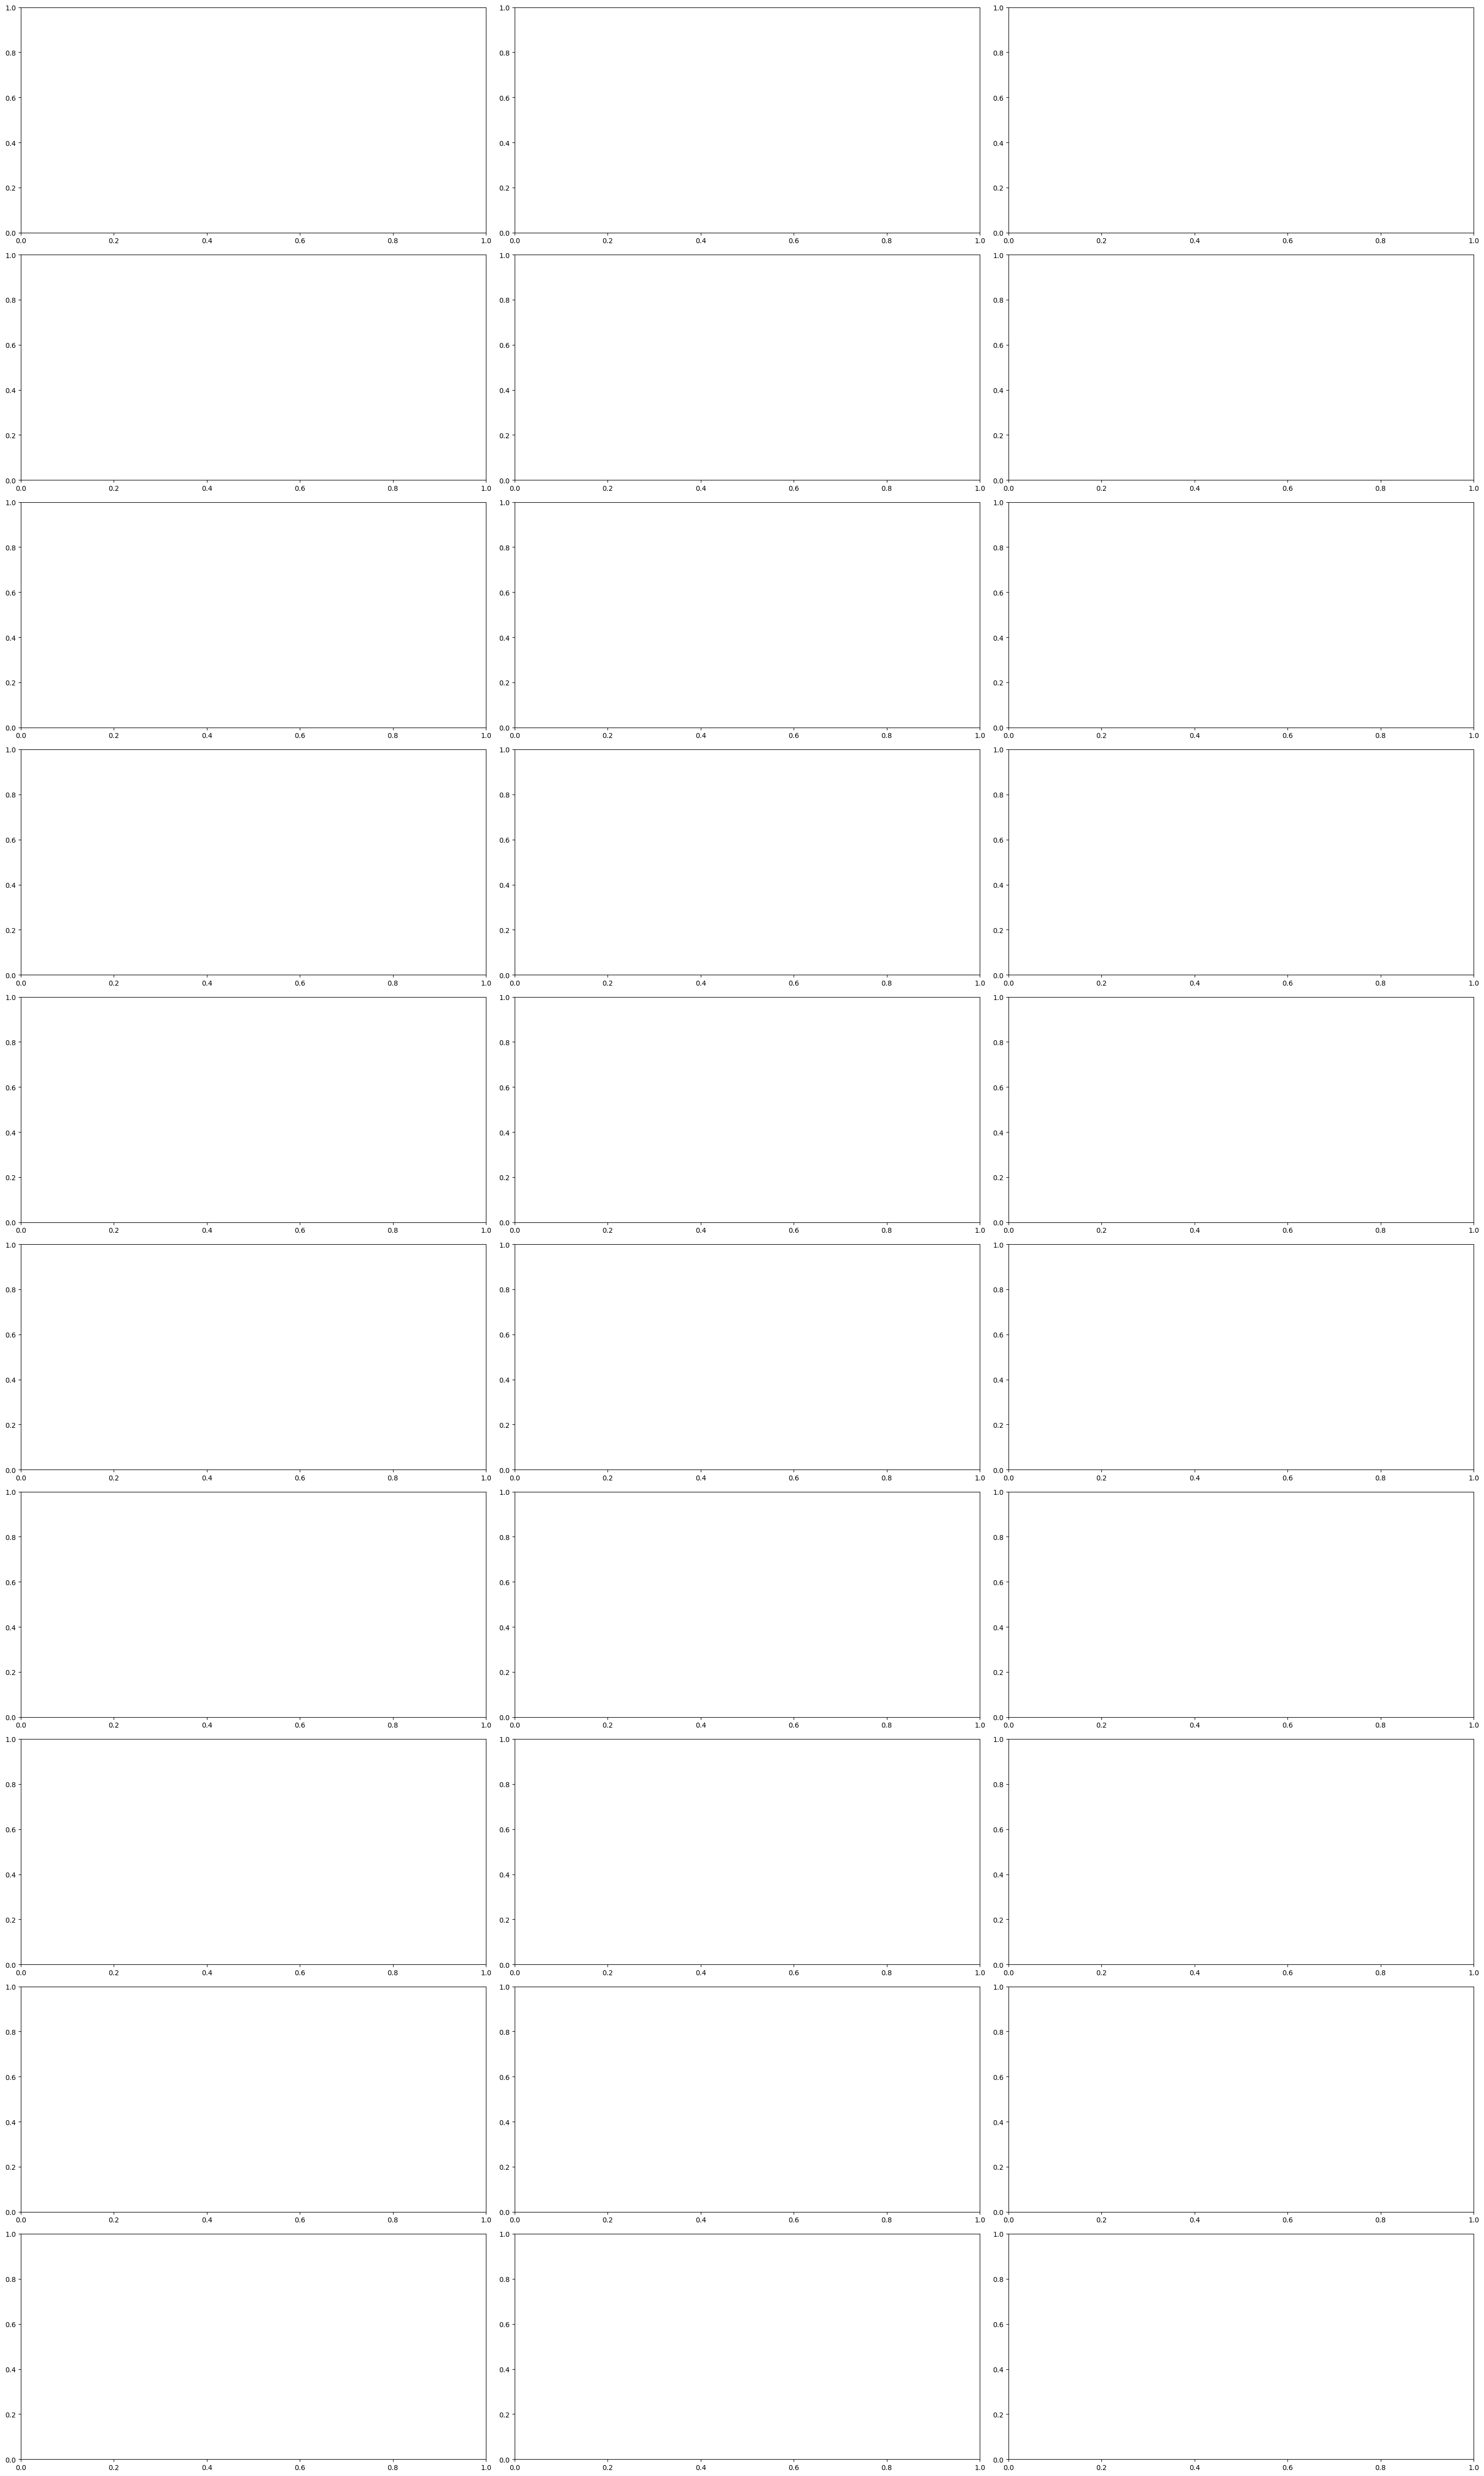

In [ ]:
count = 0
fig, axs = plt.subplots(10, 3, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Wood")
    axs[count][0].imshow(img)

    # Obtain the mask for the image
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    count += 1

fig.tight_layout()